In [ ]:
# Step 1: Imports and Constants
import tensorflow as tf
import cv2
import numpy as np
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/My Drive/Colab Notebooks/Data"
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Step 2: Photometric Augmentation Function
def photometric_augment(img, mode=1):
    """
    Applies a specific photometric transformation:
    mode 1: Color Jitter: Random brightness/contrast/hue
    mode 2: Channel Shuffling: Swap RGB channels
    mode 3: Solarization: Invert colors above threshold
    mode 4: CLAHE: Contrast-limited adaptive histogram equalization
    Returns (transformed_image, original_image)
    """
    original_img = img.copy()

    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    if mode == 1:
        # Color Jitter: random brightness and contrast
        brightness = random.uniform(0.6, 1.4)
        contrast = random.uniform(0.6, 1.4)
        img = cv2.convertScaleAbs(img, alpha=contrast, beta=int((brightness - 1) * 128))

    elif mode == 2:
        # Channel Shuffle
        img_aug = img.copy()
        channels = [0, 1, 2]
        np.random.shuffle(channels)
        img_aug = img_aug[:, :, channels]

    elif mode == 3:
        # Solarization
        threshold = 128
        img = np.where(img < threshold, img, 255 - img).astype(np.uint8)

    elif mode == 4:
        # CLAHE
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return img.astype(np.float32) / 255.0, original_img


In [ ]:
#Step 3: Visualization Function
def visualize_photometric_augmentation(image_paths, mode):
    """
    Display 5 original vs transformed image pairs for a specific augmentation mode
    """
    fig, axs = plt.subplots(5, 2, figsize=(8, 15))
    fig.suptitle(f'Photometric Augmentation Mode {mode}', fontsize=16)

    for i, path in enumerate(image_paths[:5]):
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        transformed, original = photometric_augment(img_array, mode=mode)

        axs[i, 0].imshow(original.astype(np.uint8))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(transformed, 0, 1))
        axs[i, 1].set_title("Transformed")
        for j in range(2):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


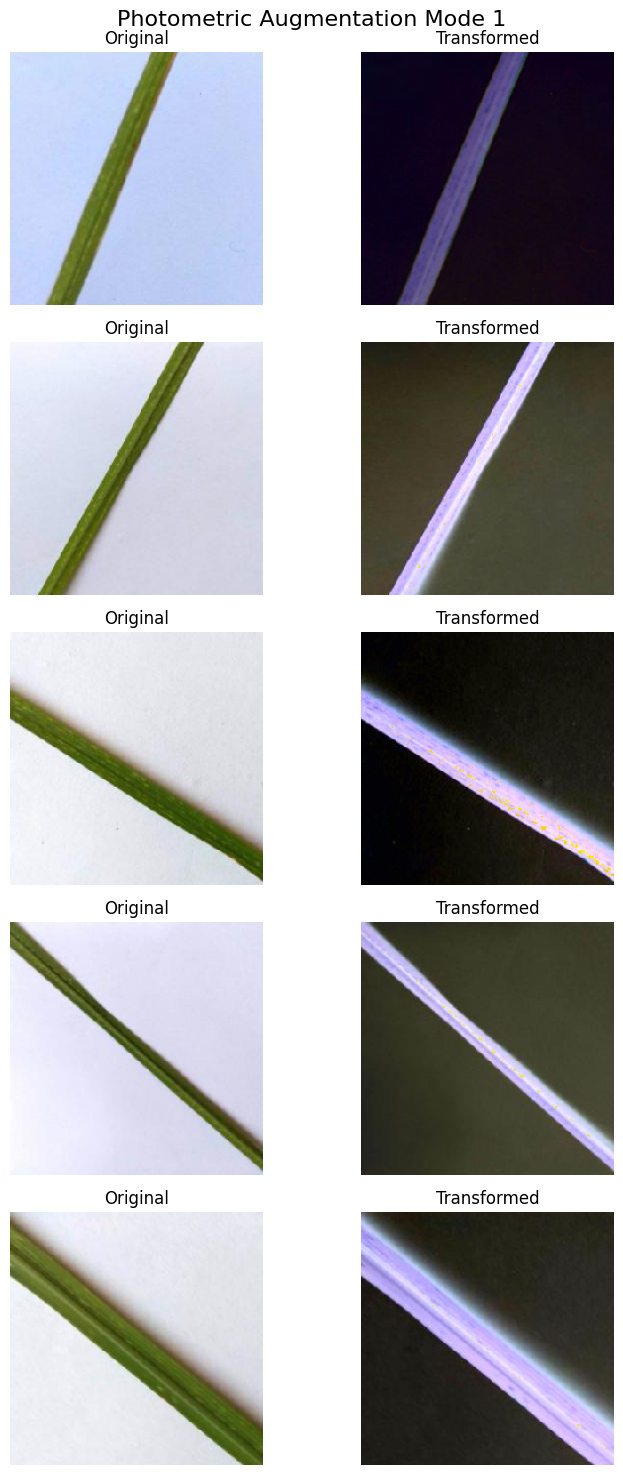

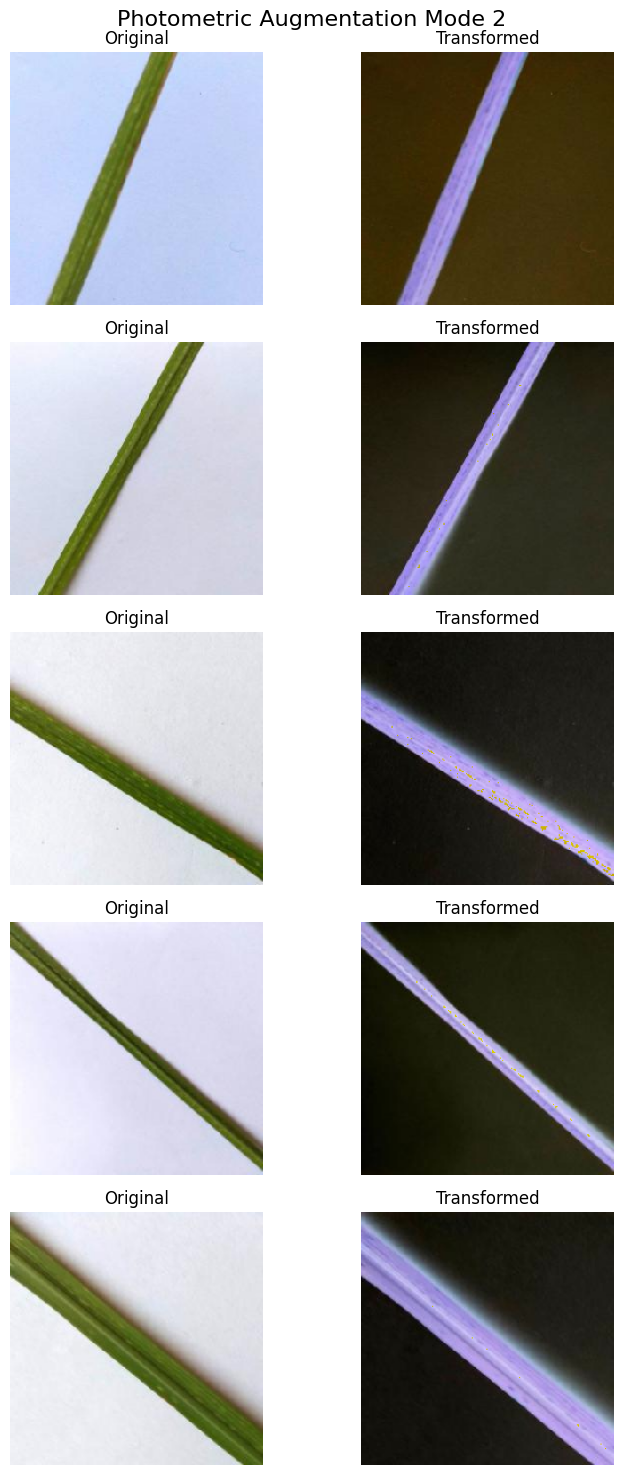

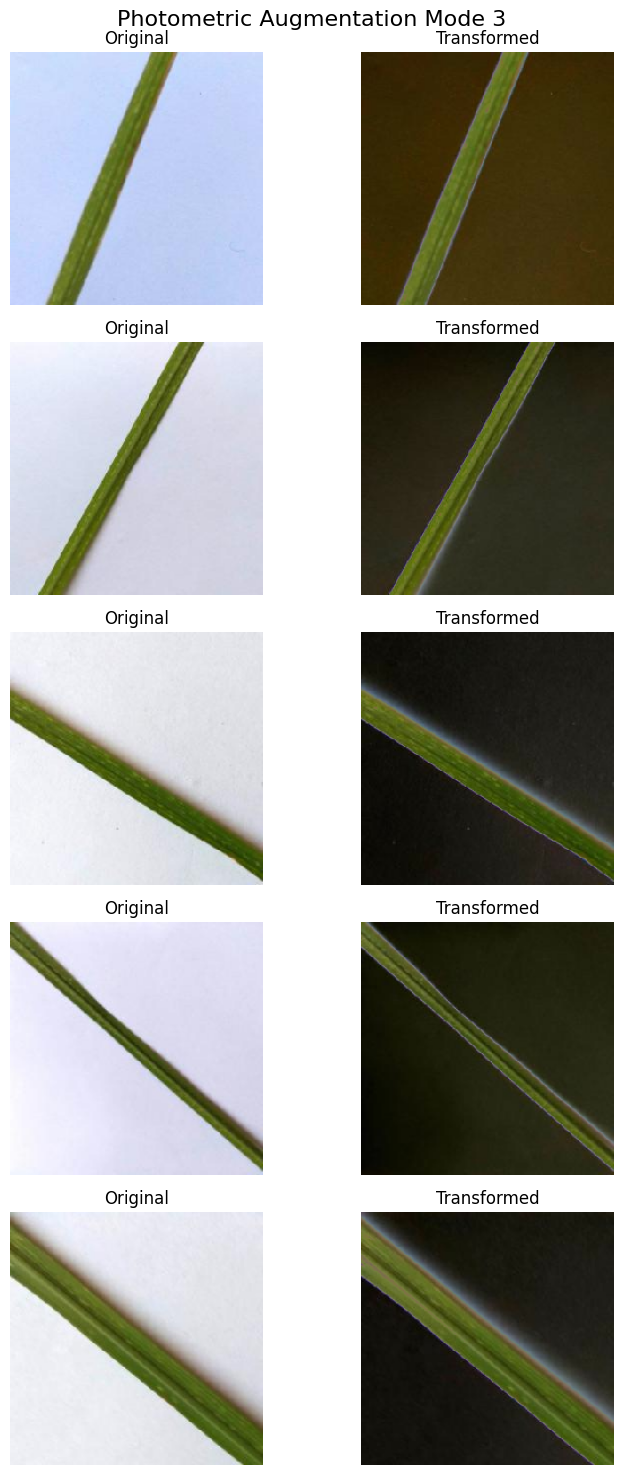

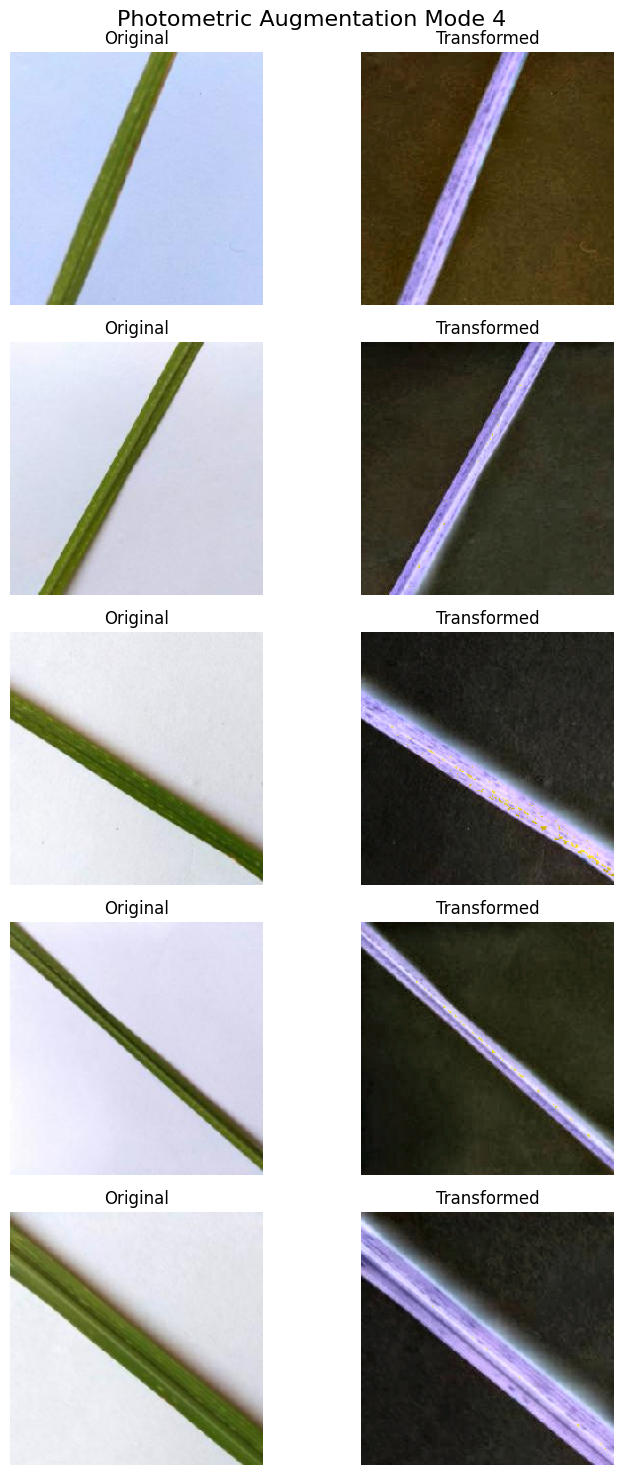

In [ ]:
#Load Sample Image Paths and Visualize
# Select 1 class folder to sample images from
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
example_class_dir = os.path.join(train_dir, class_dirs[0])

example_image_paths = [
    os.path.join(example_class_dir, f) for f in os.listdir(example_class_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Visualize for each transformation mode
for mode in range(1, 5):
    visualize_photometric_augmentation(example_image_paths, mode=mode)

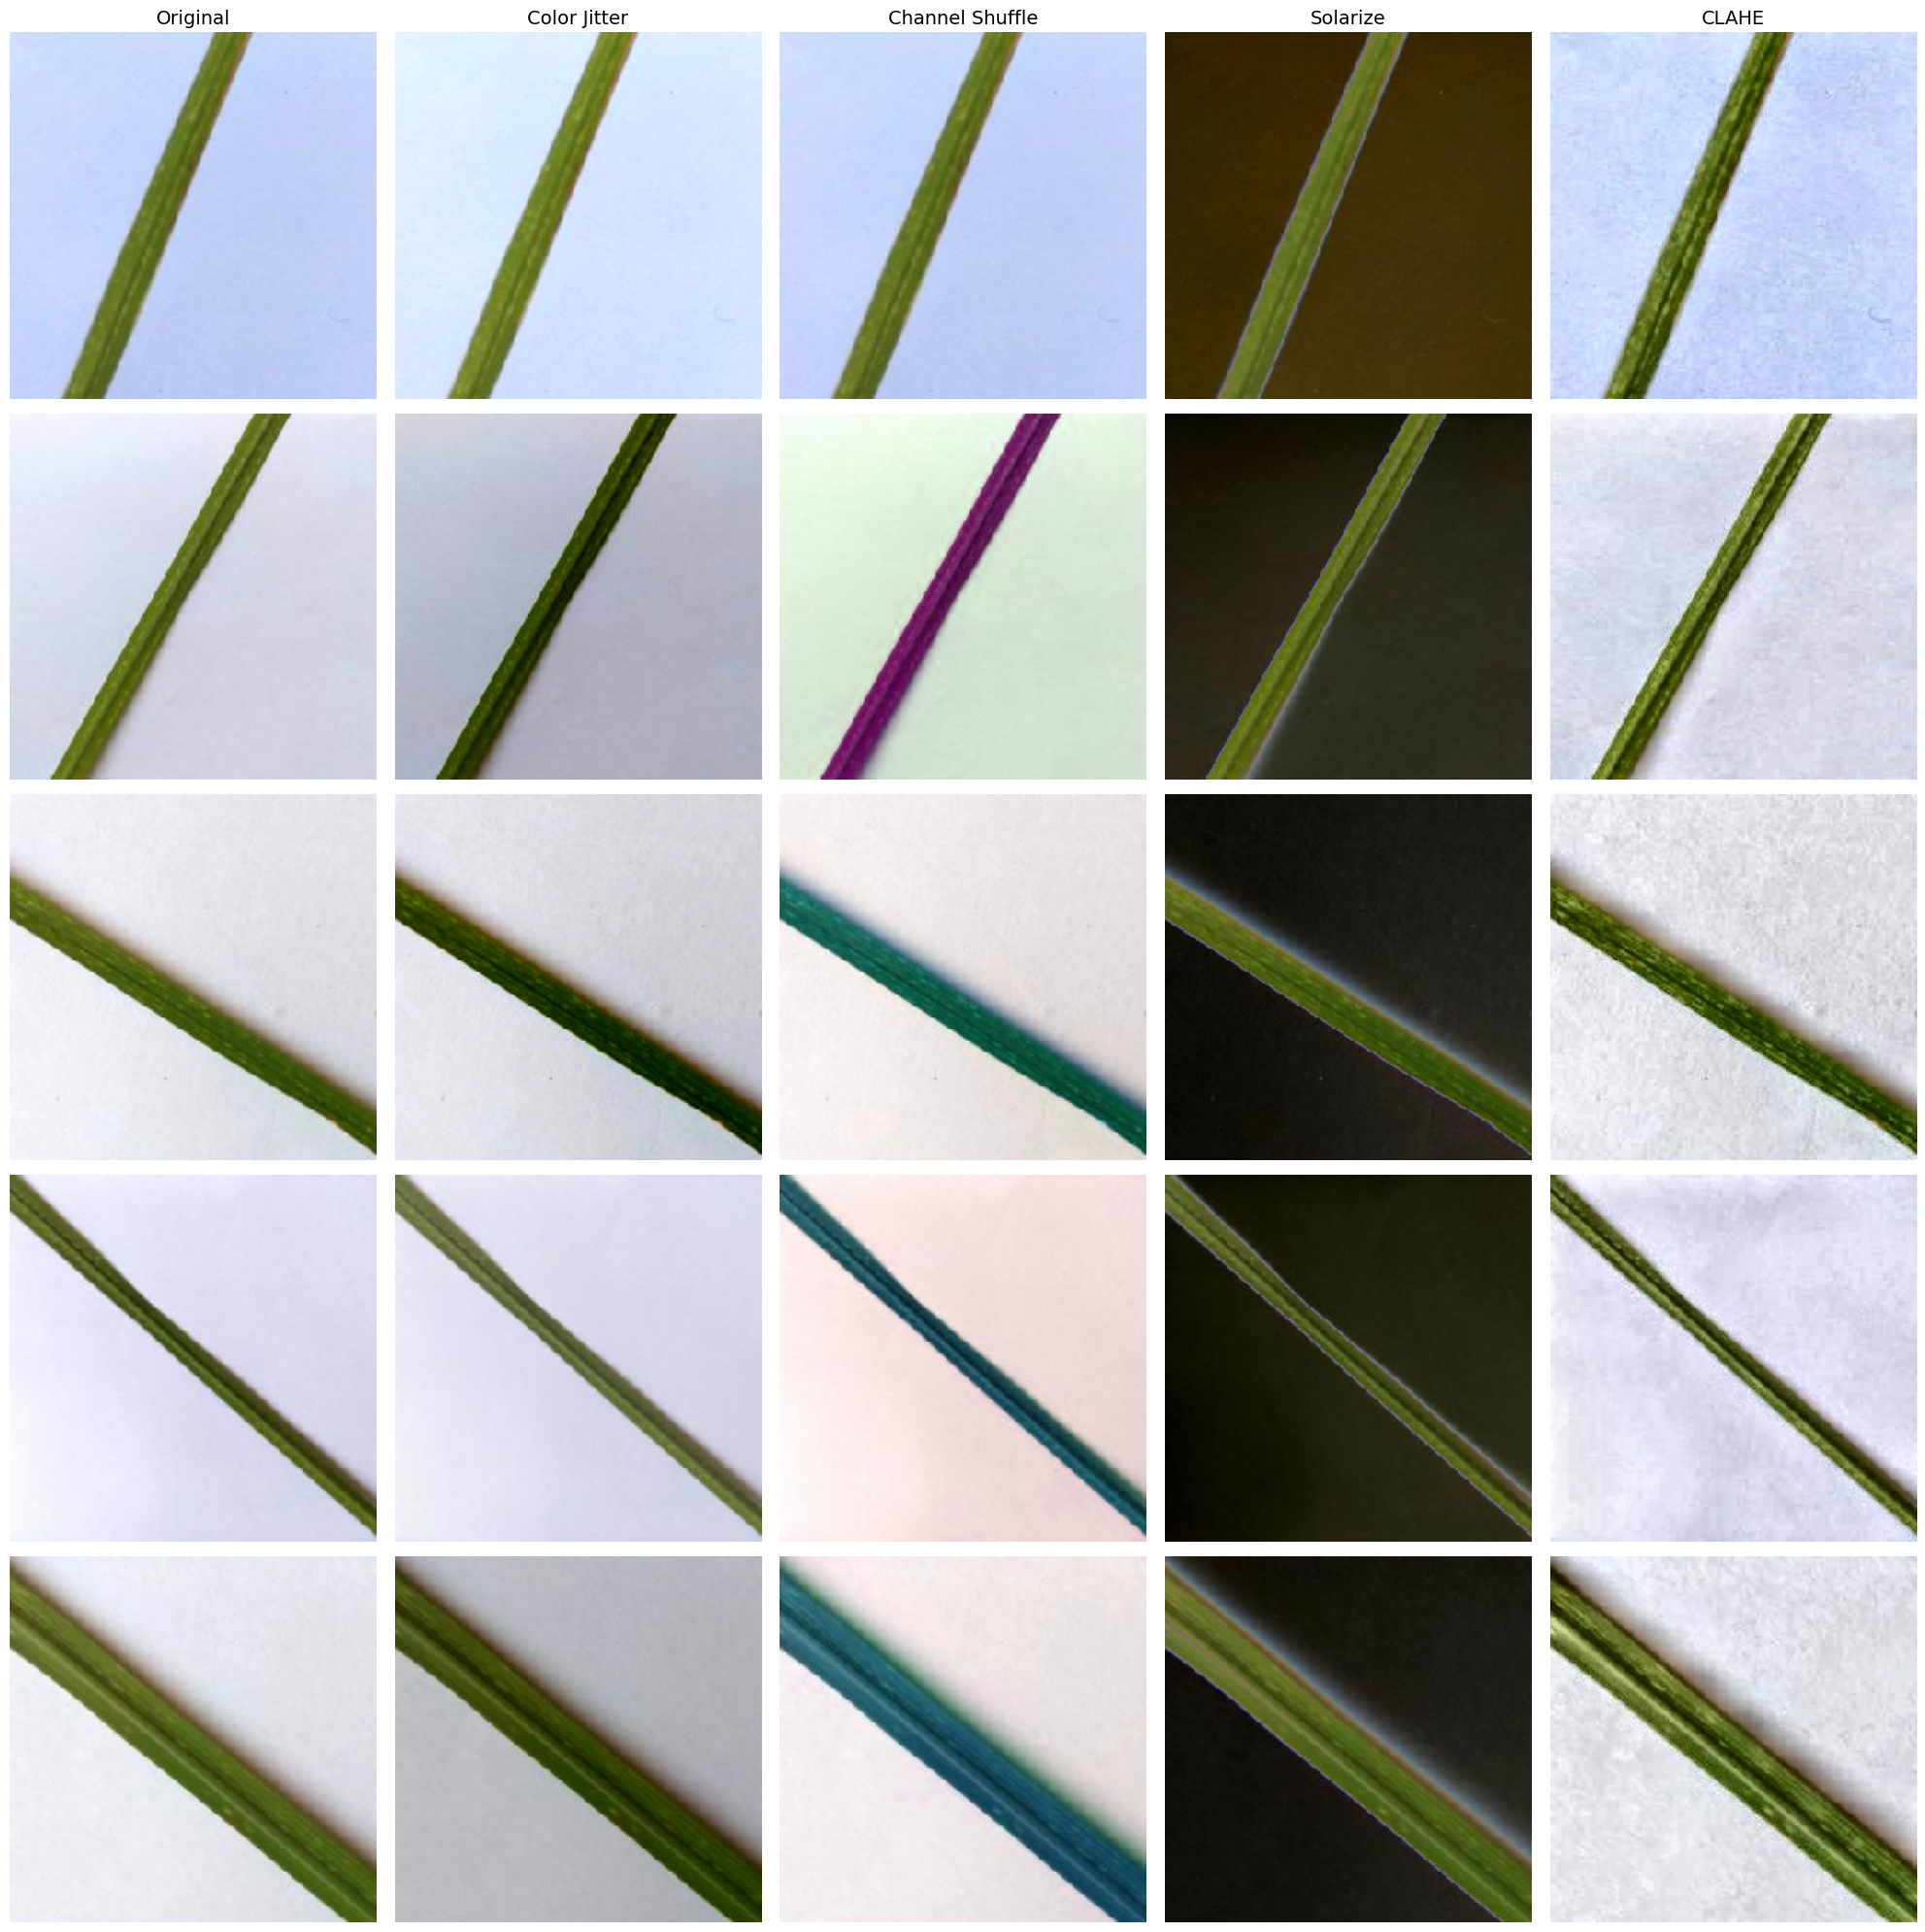

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import random_brightness, random_contrast, rgb_to_hsv, hsv_to_rgb
# Collect image paths
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
example_class_dir = os.path.join(train_dir, class_dirs[0])

example_image_paths = [
    os.path.join(example_class_dir, f)
    for f in os.listdir(example_class_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Image size for consistency
IMG_SIZE = (224, 224)

# CLAHE helper
def apply_clahe(image):
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB) / 255.0

# Photometric Augmentation Modes
def photometric_augment(img, mode):
    img = img / 255.0  # Normalize to [0,1]
    if mode == 1:  # Color Jitter (Brightness, Contrast, Hue)
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        img = random_brightness(img, max_delta=0.2)
        img = random_contrast(img, lower=0.8, upper=1.2)
        img = tf.clip_by_value(img, 0.0, 1.0).numpy()
    elif mode == 2:  # Channel Shuffling
        channels = [0, 1, 2]
        np.random.shuffle(channels)
        img = img[:, :, channels]
    elif mode == 3:  # Solarization (invert above threshold)
        threshold = 0.5
        img = np.where(img > threshold, 1.0 - img, img)
    elif mode == 4:  # CLAHE
        img = apply_clahe(img)
    return img

# Visualize: original + 4 augmentations
def visualize_all_augmentations(image_paths):
    num_images = len(image_paths[:5])
    fig, axs = plt.subplots(num_images, 5, figsize=(20, 4 * num_images))

    for i, path in enumerate(image_paths[:5]):
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img)

        imgs = [img_array / 255.0]  # original
        for mode in range(1, 5):
            augmented = photometric_augment(img_array.copy(), mode)
            imgs.append(augmented)

        for j in range(5):
            ax = axs[i, j] if num_images > 1 else axs[j]
            ax.imshow(imgs[j])
            ax.axis('off')
            if i == 0:
                titles = ['Original', 'Color Jitter', 'Channel Shuffle', 'Solarize', 'CLAHE']
                ax.set_title(titles[j], fontsize=14)

    plt.tight_layout()
    plt.show()

# 🔍 Run visualization
visualize_all_augmentations(example_image_paths)
